# Depth First Search – Using DFS to solve nxn edge matching grid puzzle

## Edge Matching Puzzle

The puzzle can be found in many different nxn grid sizes and many different ways, but the underlying problem is always the same: **given $m^2$ tiles, find  an $m$x$m$ grid such that for each tile $tile_{i,j}$, its edges match the edges of its neighboring tile (i.e. the bottom edge of $tile_{i-1,j}$ matches the top edge of $tile_{i,j}$.**

For our example, we will look at *Professor McBrainy's Zany out of this WORLD puzzle*. This puzzle consist of 16 tiles (so solving for a 4x4 grid), where each tile has a planetary symbol on each edge. There are 8 total planetary symbols to be represented on an edge, and there is no constraint about having duplicate symbols on the same tile.

In general for this problem, if we assume there are no symmetric cards, the number of ways we can lay down the tiles on the square grid is $n*n-1*n-2*...*1=n!$, where $n$ is the number of tiles and $\sqrt{n}\in\mathbb{N}, n>0$. Since each card is square, it can be rotated four times to give a new possible laydown, giving $(4*n)*(4*(n-1))*...*4=n!*4^n$ total possibilities. Finally, since the $m$x$m$ grid ($m=\sqrt{n}$)can be rotated 4 times in its final state, we divivde by four to get unique solutions, giving us $n!*4^{n-1}$ possible ways to layout the grid. **NOTE** The author of this notebook defines $\mathbb{N}=\{0,1,2,...\}$, specifically noting that we say $0\in\mathbb{N}$.

In the context of our chosen puzzle, this is $16!*4^{15}\approx2.24*10^{22}$ possible grids. For now we assume one of those grids is correct. We can see very clearly that to solve this type of problem in a bruteforce manner will result in computation times well beyond feasibility. We must implement an algorithm that will achieve a time complexity that won't take years to solve.

## DFS

**Depth First Search (DFS)** is a basic algorithm that can be best described in the traversal of a binary tree. Specifically, we will consider the *pre-order* traversal of a binary tree. Pre-order traversal can be defined as follows: *If we start at a node in a binary tree, pre-order travel has that we "visit" the current node first, then the left subtree, then the right subtree.* 

Lets consider the following tree:

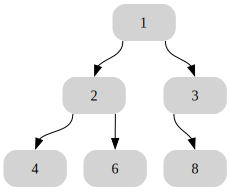

In [1]:
from binarytree import Node, tree
from IPython.display import Image, display

root = Node(1)
root.left = Node(2)
root.right = Node(3)
root.left.left = Node(4)
root.left.right = Node(6)
root.right.left = Node(8)

graph = root.graphviz()
display(graph)

In the tree above, if we were to perform tree order travel and append our visited nodes to a list in order of visitation, we would get `[1, 2, 4, 6, 3, 8]`. We can implement this in code with a recursive function calling scheme like so:
```python
def pre_order_traversal(root: Node) -> None:
    if root is not None:
        print(root.val)
        pre_order_traversal(root.left)
        pre_order_traversal(root.right)
```
The above code has $O(N)$ time complexity for $N=\#\ nodes$, since we visit every single node in the tree.

We can define DFS in a similar manner. Say we want to find a target value $val$ in a binary tree. We could use the following code to achieve this with $O(N)$ time complexity:
```python
def dfs(root: Node) -> None:
    if root is None:
        return
    
    if root.val = val:
        return root
    left = dfs(root.left)
    if left is not None:
        return left
    
    return dfs(root.right)
```
Here we introduce **backtracking** and **divide and conquer** – when we find leaf node and no solution, we backtrack and search the right subtree, and we do this for both the left and the right subtree of the root to divide and conquer the search. We are still achieving $O(N)$, where now we refer to $O(N)$ as linear time complexity.

## Backtracking and Pruning

The concept of backtracking is particularly useful in combinatorial problems, which is what we are working with here. If we think of our laying our tiles out on our $m$x$m$ grid as nodes, with the edges of the tree being related to the symbols on edges of the tile, we can create a *search space tree*, which will have all combinations possible in it. This means we could in theory apply some form of DFS onto this tree and find the solution to the edge matching problem.

Looking at our search space tree though, from the math above we see that traversing every possible branch in the tree is just not feasible. This is where we can leverage **pruning** to back out of trees that do not yield a solution. As we explore the search-space, we are constructing our search-space tree as we go, hoping that we travel down a path that leads to the solution. If we place the third tile down, and find that no card is able to satisfy the edge matching condition for the fourth card, then rather than constructing the tree all the way to the 4x4 solution (in our *out of this WORLD* puzzle space), we declare the subtrees incorrect and prune them from our solution space. This allows us to reduce computation time by systematically exiting subtrees that will not lead to a solution (because an early branch cannot meet the requirements).

## Solving the Puzzle Using DFS with Pruning

Now we will look to implement an agorithm to search for our solution. We will start with a simpler 4 tile, 2x2 grid solution to show the functionality of the code, then we will solve the good Professor McBrainy's puzzle.

### Logic at a Given Node

Say we have placed $n$ tiles down such that we now are looking to see which tiles could be a potential fit at the grid point $(i,j)$. For each tile $k$ in the set of unused tiles, we need to see if it is valid compared to the card immidiately left of it and immediately above it ($tile_{i,j-1}\ and\ tile_{i-1,j}$). What this really means is that we need to ensure that: 
1) The right edge of $tile_{i,j-1}$ matches the left edge of $tile_{i,j}$
    - If there is no tile to the left of $tile_{i,j}$ then condition (1) is automatically met
2) The bottom edge of $tile_{i-1,j}$ matches the top edge of $tile_{i,j}$
    - If there is no tile above $tile_{i,j}$ then condition (2) is automatically met

If both conditions are met then we place the tile at position $(i,j)$ and we start searching the subtrees of that card. Once we fill the grid, we back all the way out and return a list containing the tile laydown in a 4x4 grid.
If either condition is not met, we can: a) rotate the current tile if it already has not been rotated to the other three positions, or b) if we have alraedy searched the rotation space of the current tile, prune that card and its subtree of possible tile placements from our search space tree and move onto the next unplaced card.
Now, if we can't find any card that meets the neighbor requirement, we then backtrack to our previous placement and search through the remaining cards we did not check for that position. This recurively continues. The beauty here is that rather than exploring each cards subtree hoping we find the solution, we apply our constraints and eliminate subtrees when we find a tile cannot be placed. This greatly reduces the number of nodes we traverse down, leading to better time performance.

### Encoding the Cards

In the intro we mentioned that the symbols in the *out of this WORLD* are planets. How do we pass the available cards into our code? We will encode each tile in a list of length 4, where the entries are the left, top, right, and bottom symbol, in that order. Each list is embedded in a list of lists, which we will feed into our function. We encode each symbol as follows:
$$
Earth\rightarrow 1
$$
$$
Moon\rightarrow 2
$$
$$
Mars\rightarrow 3
$$
$$
Saturn\rightarrow 4
$$
$$
Orange Planet\rightarrow 5
$$
$$
Green Planet\rightarrow 6
$$
$$
Purple Planet\rightarrow 7
$$
$$
Io\rightarrow 8
$$
For example ```[3,4,8,1]``` is a tile that has a left edge symbol Mars, top edge symbol of Saturn, right edge symbol of Io, and a bottom edge of Earth.

### In Code

We will work with python to construct our algorithm. The full solver will be shown first, with the individual components beign defined as the solution is walked through.
```python
def solve_puzzle(input_cards: list[list[int]], grid_size: int) -> list[list[int]]:
    '''
    `solve_puzzle`: Given a list of `input_cards`, where each entry in the list is a list encoding a 4-side tile with symbols from left, top, right, bottom, and a `grid_size` for the final MxM solution, use DFS with pruning to find a grid where al tiles have matching edges.
    
    Inputs
    ------
    `input_cards : list[list[int]]`
    - List of input tiles, with encoded values representing the symbol on each edge
    
    `grid_size : int`
    - An integer representing the side length of the the MxM grid that we want to solve for.
    
    Returns
    -------
    `ans : list[list[int]]`
    - MxM array representing the solved state of the puzzle. All entries are `None` if no solution was found. 
    '''
    
    ans = [[None for _ in range(grid_size)] for _ in range(grid_size)]
    all_rots = get_all_rotations(input_cards)
    used_tiles = [False] * grid_size**2
    
    pos = 0 

    def dfs_for_grid(pos: int) -> bool:
        '''
        `dfs_for_grid`: Given a position index, find a valid tile in the edge-matching puzzle for teh current position using a Depth First Search implementation with pruning. Recursively search for more solutions when one is found for the current `pos` input. The position in the grid we are trying to fill is colculated by doing the integer division between the grid size of our solution for the row values, and the modulo with the grid size of our solution, with respectto `pos`
        
        Inputs
        ------
        `pos : int`
        - Integer representing the current number tile position we are trying to find a solution for. Used to calculate the row, column values we are at.
        
        Returns
        -------
        `res : bool`
        - Returns `True` if we have found a solution, otherwise returns `False`
        '''
        if pos == grid_size**2:
            return True
        
        i = pos // grid_size
        j = pos % grid_size

        res = False

        for card_idx in range(len(used_tiles)):
            
            if used_tiles[card_idx]:
                continue

            rotations = all_rots[card_idx]

            left_neighbor = ans[i][j-1] if j > 0 else (None)
            top_neighbor = ans[i-1][j] if i > 0 else (None)

            for rot in range(4):
                card = rotations[rot]
                
                if is_valid(potential_neighbor=card, left_neighbor=left_neighbor, top_neighbor=top_neighbor):
                    ans[i][j] = card
                    used_tiles[card_idx] = True
                    res = dfs_for_grid(pos+1)
                    if res:
                        return res 
                    else:
                        ans[i][j] = None
                        used_tiles[card_idx] = False
        return res
    
    res = dfs_for_grid(pos)

    return ans
```

We define our solver ```solve_puzzle``` with the following inputs:
- ```input_cards``` is the list of tile encoding lists, in no particular order.
    - **NOTE** The order will affect how fast we converge on a solution, so we will have to randomize this multiple times and solve each perumtation to get a good idea of runtime.
- ```grid_size``` is the edge size of the final grid (```grid_size=4``` for a $4$x$4$ grid)

To track what cards we have placed and output the final solution, we initialze an $m$x$m$ array ```ans```, where each element is ```None```. We then take our input cards, and we pre-calculate the possible rotation states of each card and return them as tuples. We can quickly examine the code that performs this for us:
```python
def get_all_rotations(cards: list[list[int]]) -> tuple[tuple[int]]:
    '''
    `get_all_rotations`: Given a list of square card encodings, for each card, get the four rotation state representations and append them to a list. The output is a tuple containing tuples for each card containing tuples of the rotated encodings. Rotations are done clockwise by 90 degrees

    Inputs
    ------
    `cards : list[list[int]]`
    - list of all card encodings to calculate rotations for
    
    Returns
    -------
    `cards_all_rot : tuple[tuple[tuple[int]]]`
    - input card rotated n times 90 degrees clockwise
    '''
    
    cards_all_rots = []
    for card in cards:
        rots = [card]
        for _ in range(3):
            rots.append(tuple(card[-1:] + card[:-1]))
        
        cards_all_rots.append(tuple(rots))
        
    return tuple(cards_all_rots)
```
Here we take in a list of cards (cards available for the solution in our case), and for each card, we create a list, and append the three other rotation states of the card, as tuples. We then save that new tuple of the four rotation states to a tuple of tuples, where for the outer most tuple, each index represents a card. We use tuples for faster computation, and we pre-calculate these states to avoid doing it inplace during the DFS, which would introduce a lot of overhead into our algorithm.

Back to `solve_puzzle`: after getting the rotation states, we define `used_tiles`, which is a list with $grid_size^2$ entries, which we initialize to false indicating that we have not placed that card yet. Finally, we define ```pos``` is a input index tracker for the whole array, so we say $pos=\{\mathbb{N} | 0\leq pos \leq n\}$, where $n$ is the number of tiles. This always us to only track one index, and we will define the row and col indices within the DFS function. After defining our DFS with pruning function, we call ```dfs_for_grid``` with the initial index ```pos=0```, and return the found solution grid ```ans```.

Lets now look at our DFS function:
```python
def dfs_for_grid(pos: int) -> bool:
        '''
        `dfs_for_grid`: Given a position index, find a valid tile in the edge-matching puzzle for teh current position using a Depth First Search implementation with pruning. Recursively search for more solutions when one is found for the current `pos` input. The position in the grid we are trying to fill is colculated by doing the integer division between the grid size of our solution for the row values, and the modulo with the grid size of our solution, with respectto `pos`
        
        Inputs
        ------
        `pos : int`
        - Integer representing the current number tile position we are trying to find a solution for. Used to calculate the row, column values we are at.
        
        Returns
        -------
        `res : bool`
        - Returns `True` if we have found a solution, otherwise returns `False`
        '''
        if pos == grid_size**2:
            return True
        
        i = pos // grid_size
        j = pos % grid_size

        res = False

        for card_idx in range(len(used_tiles)):
            
            if used_tiles[card_idx]:
                continue

            rotations = all_rots[card_idx]

            left_neighbor = ans[i][j-1] if j > 0 else (None)
            top_neighbor = ans[i-1][j] if i > 0 else (None)

            for rot in range(4):
                card = rotations[rot]
                
                if is_valid(potential_neighbor=card, left_neighbor=left_neighbor, top_neighbor=top_neighbor):
                    ans[i][j] = card
                    used_tiles[card_idx] = True
                    res = dfs_for_grid(pos+1)
                    if res:
                        return res 
                    else:
                        ans[i][j] = None
                        used_tiles[card_idx] = False
        return res
```

Our DFS function only takes in the current position we are considering for card placement, ```pos```. 

The first thing is **the most important part of the function: the base case**. If we find that `pos` is equal to the square of the ```grid_size``` parameter, then we have found a solution, and we need not do anymore searching. We return ```True``` so that we can propogate up through our recurive calling that we found the solution. 

We define which row ```i``` and which col ```j``` we are trying to fill if `pos<grid_size**2`. We initialize the result of our search to be ```res=False```, so that if we don't reach the base case, we know to prune the branch. We start by iterating over all input cards, and skip cases where we have placed a cards in the `ans` grid (`used_tile[card_idx]==True`). If we haven't palced the card, we extract the four rotation states of it from `all_rots`, and then exrtact the left and top neighbor of position $(i,j)$ from the `ans` array where we store the placed tiles in the grid positions. We set a neighbor to ```[None]``` if the neighbor doesn't exist (i.e. the tile position is on the outer edge of the grid). 

We then iterate over the four rotation states of the card, and check whether the given state ```card``` is valid at $(i,j)$, by passing it through a helper function ```is_valid```. This function applies the logic we outlined at a given node, and is defined as followed:
```python
def is_valid(potential_neighbor: tuple[int], left_neighbor: tuple[int]=[None], top_neighbor: tuple[int]=tuple[None]) -> bool:
    '''
    `is_valid`: Checks if `potential_neighbor` is a valid neighbor of 'left_neighbor` and `top_neighbor` by checking if connected edges share the same value.
    Returns `True` if so, otherwise it returns `False`

    Inputs
    ------
    `potential_neighbor : tuple[int]`
    - Card we are testing as a potential solution for the tile position $(i,j)$
    
    `left_neighbor : tuple[int]`
    - The card at position $(i,j-1)$ relative to the `potential_neighor`
    
    `top_neighbor : tuple[int]`
    - The card at position $(i-1,j)$ relative to the `potential_neighor`

    Returns
    -------
    `bool`
    - `True` if `potential_neighbor` has matching left and top edges to the right and bottom edges of `left_neighbor` and `top_neighbor`, respectively. If no top or left neighbor is present we consider the condition for that neighbor met.
    '''
    if left_neighbor[0] is None and top_neighbor[0] is None:
        return True
    elif left_neighbor[0] is None:
        return potential_neighbor[1] == top_neighbor[3]
    elif top_neighbor[0] is None:
        return potential_neighbor[0] == left_neighbor[2]
    else:
        return (potential_neighbor[0] == left_neighbor[2]) and (potential_neighbor[1] == top_neighbor[3])
```
The function takes three inputs ```potential_neighbor``` which is the tile we are testing, and ```left_neighbor``` and ```top_neighbor``` as the left and top neighboring tiles to the position we are trying to find an appropiate tile for. If no neighbors are present, then we pass ```True``` as this is the upper corner of the grid so it's always valid. If there is no left neighbor, we only check if the top neighbor's bottom edge matches the potential neighbor's top edge. If there is no top neighbor, we only check that the left neighbors right edge matches the potential neighbors left edge. If both neighboring tiles exist, we check that the top neighbor's bottom edge matches the potential neighbor's top edge **and** that the left neighbors right edge matches the potential neighbors left edge. If any of these are true, we return ```True```. Otherwise, ```False``` is returned and we know that tile is not a valid choice.

Going back to ```dfs_for_grid```, if ```is_valid``` returns true, we add the card to our answer grid at $i,j$ and we set the card index in `used_tiles` to be `True`. After this, we then call on ```dfs_for_grid``` with the input argument of ```pos+1```. This is a recursive call and allows for faster run times. We then check the output `res`: if `res=True`, we found the solution, so we return it to back out of our recursive calls. If `res=False`, then we remove the test tile from `ans` and set `used_tiles` to be `False` for that card.

If `is_valid` returned `False`, we iterate over the other rotation states of teh given card. If none of those pass the validity test, then we move onto the next tile in `input_cards`.

Only when we return `True` from `dfs_for_grid`, does it mean we found a solution.

## The 2x2 Case

Let's now try this on a known answer in a 2x2 case. Let us plot the solution:

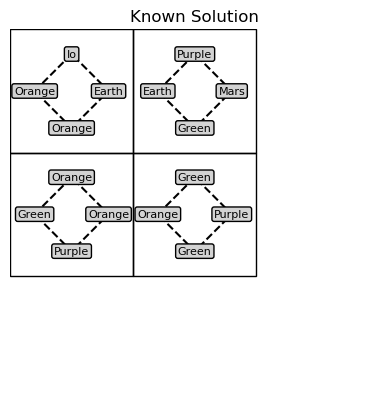

In [2]:
from utils.puzzleSolver import plot_solution
encoding_dict = {
    1: 'Earth',
    2: 'Moon',
    3: 'Mars',
    4: 'Saturn',
    5: 'Orange',
    6: 'Green',
    7: 'Purple',
    8: 'Io'
}
solution = [[(5, 8, 1, 5), (1, 7, 3, 6)], [(6, 5, 5, 7), (5, 6, 7, 6)]]
plot_solution(solution, encoding_dict, title="Known Solution")

Now lets see if the solver produces the same answer. The code explained above lives in the `puzzleSolver.py` file under the `utils` folder in this repo, so we will import the necessary code in, define our input cards, and run it through the solver:

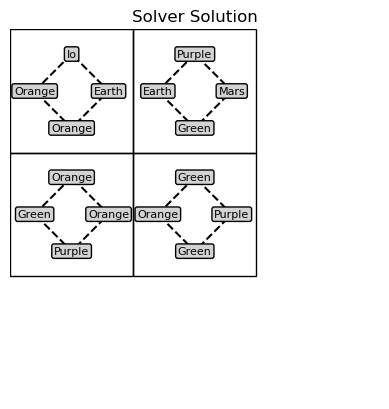

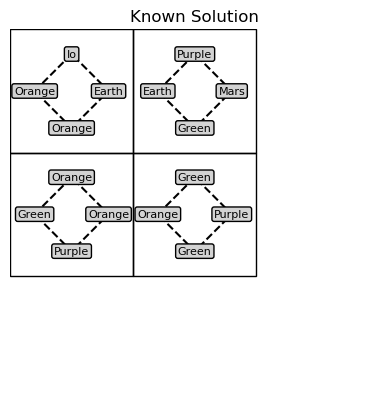

In [3]:
from utils.puzzleSolver import solve_puzzle

input_cards = [[5, 8, 1, 5], [6, 5, 5, 7], [5, 6, 7, 6], [1, 7, 3, 6]]
grid_size = 2

ans = solve_puzzle(input_cards, grid_size)
plot_solution(ans, encoding_dict, title="Solver Solution")
plot_solution(solution, encoding_dict, title="Known Solution")

We can see that the solutions appear to match. If we want absolute confirmation:

In [4]:
assert ans == solution

With no error appearing, we have that `solution==ans`!

Let's now look at the average compute time. We will randomly shuffle the input order of the input cards so that we don't initialize the same way everytime and have bias in our convergence time:

In [5]:
from time import time
import pandas as pd
from random import shuffle

time_series = pd.Series(index=[i for i in range(100)], dtype='float64')

for i in range(100):
    shuffle(input_cards)
    t0 = time()
    _ = solve_puzzle(input_cards, grid_size)
    t1 = time()
    time_series.iloc[i] = t1-t0
        
print(f"The average run time for the 2x2 grid is: {time_series.mean()} seconds.")
    

The average run time for the 2x2 grid is: 3.145933151245117e-05 seconds.


## Professor McBrainy's Zany out of this WORLD 4x4

We will now use the code to solve and display the solution the algorithm finds:

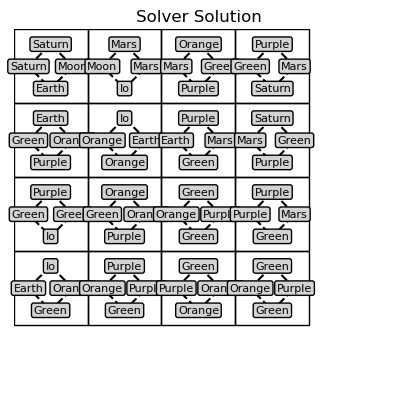

In [6]:
input_cards = [
    [4,4,2,1],
    [6,1,5,7],
    [6,7,6,8],
    [1,8,5,6],
    [5,7,7,6],
    [6,5,5,7],
    [5,8,1,5],
    [2,3,3,8],
    [3,5,6,7],
    [1,7,3,6],
    [5,6,7,6],
    [7,6,5,5],
    [5,6,7,6],
    [7,7,3,6],
    [3,4,6,7],
    [6,7,3,4]
]
grid_size = 4

ans = solve_puzzle(input_cards, grid_size)
plot_solution(ans, encoding_dict, title="Solver Solution")

We can confirm the solution by using the actual puzzle to show the solution we found using the solver:

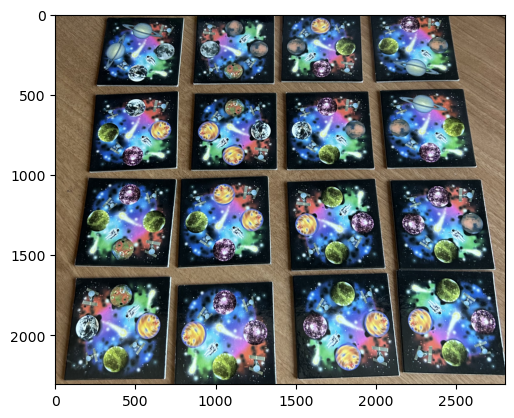

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from pillow_heif import register_heif_opener

register_heif_opener()
image = Image.open("./images/IMG_0059.HEIC")
_ = plt.imshow(image)

We can see that we did indeed converge on a possible solution!

Let's calculate the average run time over 100 runs the same way we did with the 2x2 grid. 

In [9]:
time_series = pd.Series(index=[i for i in range(100)], dtype='float64')

for i in range(100):
    shuffle(input_cards)
    t0 = time()
    _ = solve_puzzle(input_cards, grid_size)
    t1 = time()
    time_series.iloc[i] = t1-t0
        
print(f"The average run time for the 4x4 grid is: {time_series.mean()} seconds.")

The average run time for the 4x4 grid is: 21.77296440601349 seconds.


We can see that the average run time for the 4x4 case is $\approx10^{6}$ times longer, but if we look at how much bigger our search space is than the 2x2 case, that factor shows the efficiency of our algorithmic approach!

## Complexity

Let's quickly look at the time and space complexity of this implmentation. The easiest to start with is space: since we hold an $m$x$m$ grid, and for the `all_rots` array we hold $m^2 * 4 * 4$ values, we say our space complexity is $O(m^2)$.

Now, the time complexity of this solutionn is tricky. In the absolute worse case, we could explore $m^2$ possible tiles for a given position in the grid, with a total of $m^2!$ combinations. We also know that we look at worse case 4 rotations for each tile at each position for the $m^2$ cards. So the absolute worse case for this implementation is $O(m^2!*4^{m^2})$. Pruning helps reduce thigns so we don't truly reach the worse case, making it crucial for this implemenation to run efficiently.

## Conclusion

This notebook imlpemented Depth First Search (DFS) with pruning to solve $m$x$m$ edge-matching grid problems. We specifically wanted to use this to solve *Professor McBrainy's Zany out of this WORLD puzzle*. We started with an overview of DFS, backtracking, divide and conquer, and pruning in binary trees. We then walked through the 

problem at hand, and laid out the logic for how we could treat this as a tree search problem, thinking about each tile as a node and the edges as tree edges. We then did a detailed walk through of the code and implementation in python, translating our logic to code. 

Finally, we actually used the code to solve a simple 2x2 case to show that it would produce a correct answer given a known solution, and used this confirmation to take on Professor McBrainy's puzzle. We saw that when we translated our found solution to real life with the puzzle, we found the code did produce an actual solution state!

While this is a fun application of DFS, the applicability of it to solve very large and constrained combinatoric problems in an efficient manner should not be overlooked, and in fact kept in close thought when looking at problems in the future where the solution space seems insermountable.